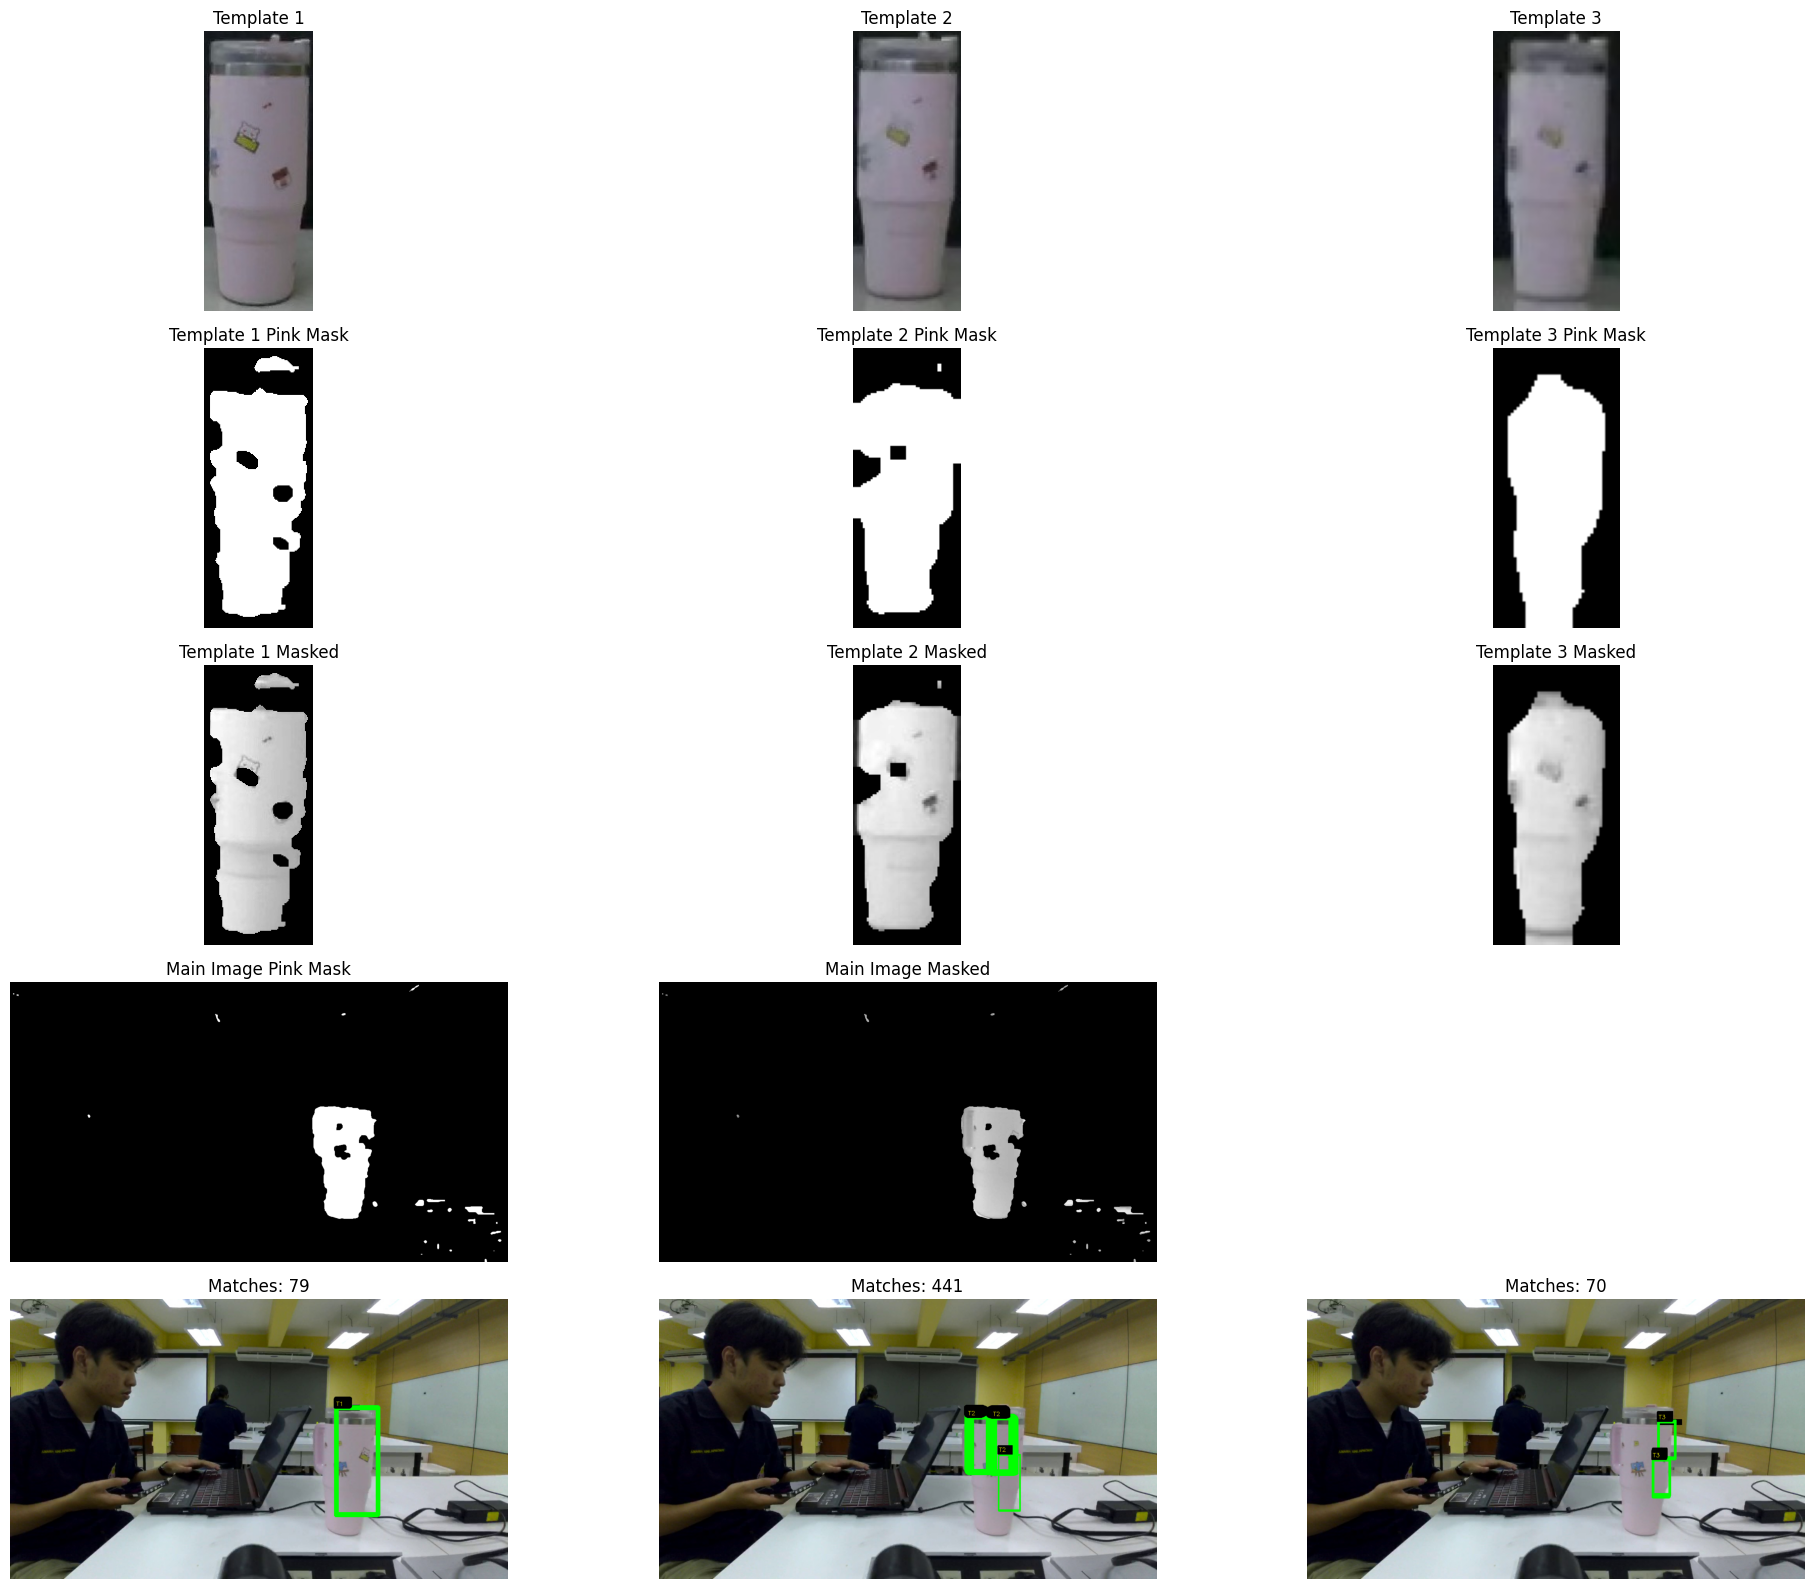

=== Template Matching with Pink Mask Results ===
Template 1: พบ 79 ตำแหน่ง
Template 2: พบ 441 ตำแหน่ง
Template 3: พบ 70 ตำแหน่ง

Threshold ที่ใช้: 0.5
Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา
ช่วยลด false positive และเพิ่มความแม่นยำในการ matching

=== Detection Details ===

Template 1:
  Detection 1: x=838, y=274, w=107, h=275
    Confidence: 0.500
  Detection 2: x=839, y=274, w=107, h=275
    Confidence: 0.500
  Detection 3: x=836, y=275, w=107, h=275
    Confidence: 0.500
  Detection 4: x=837, y=275, w=107, h=275
    Confidence: 0.504
  Detection 5: x=838, y=275, w=107, h=275
    Confidence: 0.505
  Detection 6: x=839, y=275, w=107, h=275
    Confidence: 0.505
  Detection 7: x=840, y=275, w=107, h=275
    Confidence: 0.503
  Detection 8: x=841, y=275, w=107, h=275
    Confidence: 0.501
  Detection 9: x=836, y=276, w=107, h=275
    Confidence: 0.506
  Detection 10: x=837, y=276, w=107, h=275
    Confidence: 0.509
  Detection 11: x=838, y=276, w=107, h=275
    Confiden

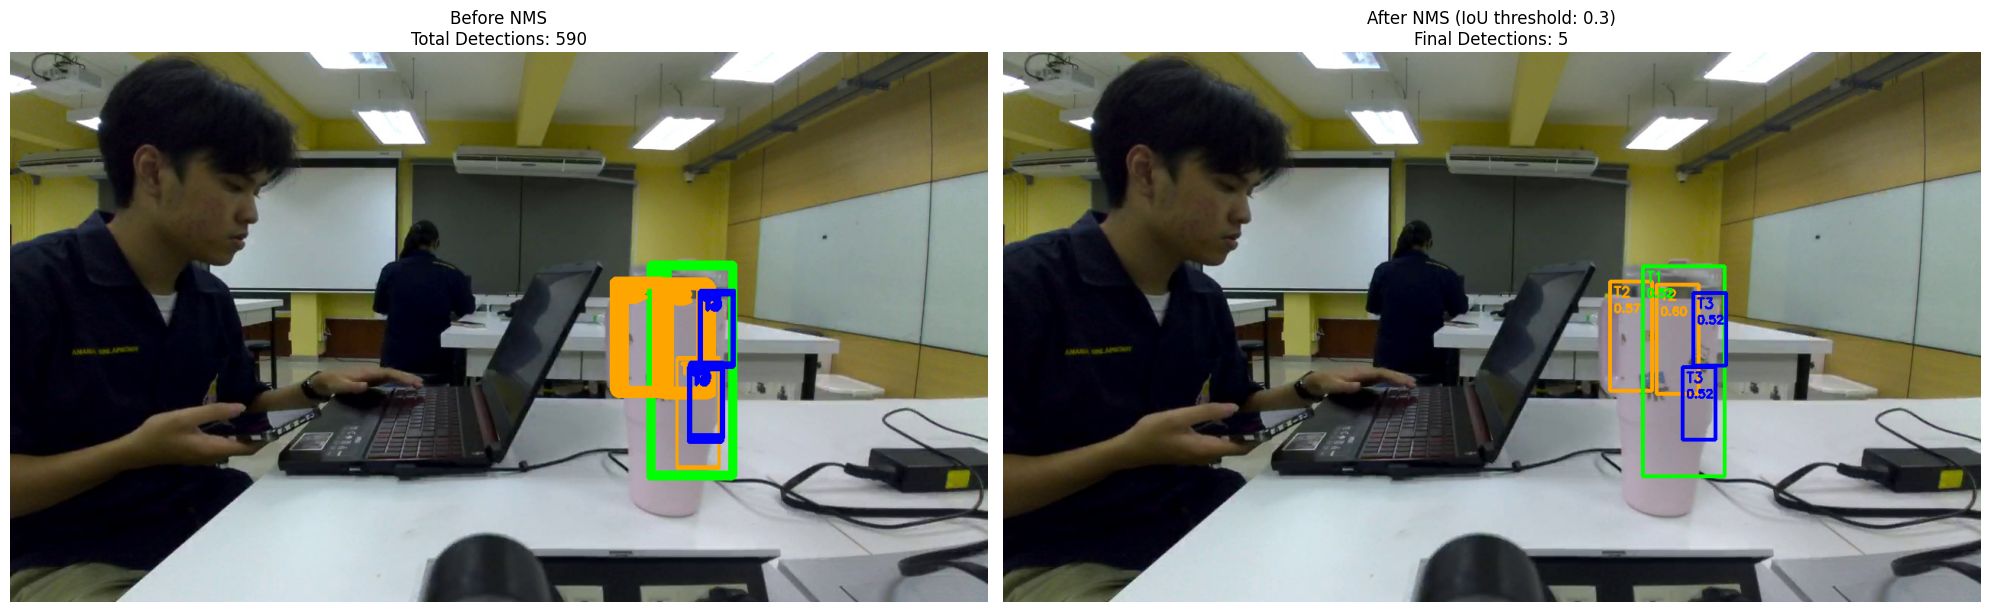

=== Non-Maximum Suppression Details ===
IoU Threshold: 0.3
Detections before NMS: 590
Detections after NMS: 5
Removed overlapping boxes: 585

=== Final Detection Results ===
Detection 1: Template T2
  Position: x=855, y=304, w=55, h=143
  Confidence: 0.601
  Color: (255, 165, 0)
Detection 2: Template T2
  Position: x=794, y=300, w=55, h=143
  Confidence: 0.566
  Color: (255, 165, 0)
Detection 3: Template T3
  Position: x=889, y=412, w=43, h=95
  Confidence: 0.522
  Color: (0, 0, 255)
Detection 4: Template T1
  Position: x=837, y=280, w=107, h=275
  Confidence: 0.521
  Color: (0, 255, 0)
Detection 5: Template T3
  Position: x=903, y=315, w=43, h=95
  Confidence: 0.516
  Color: (0, 0, 255)


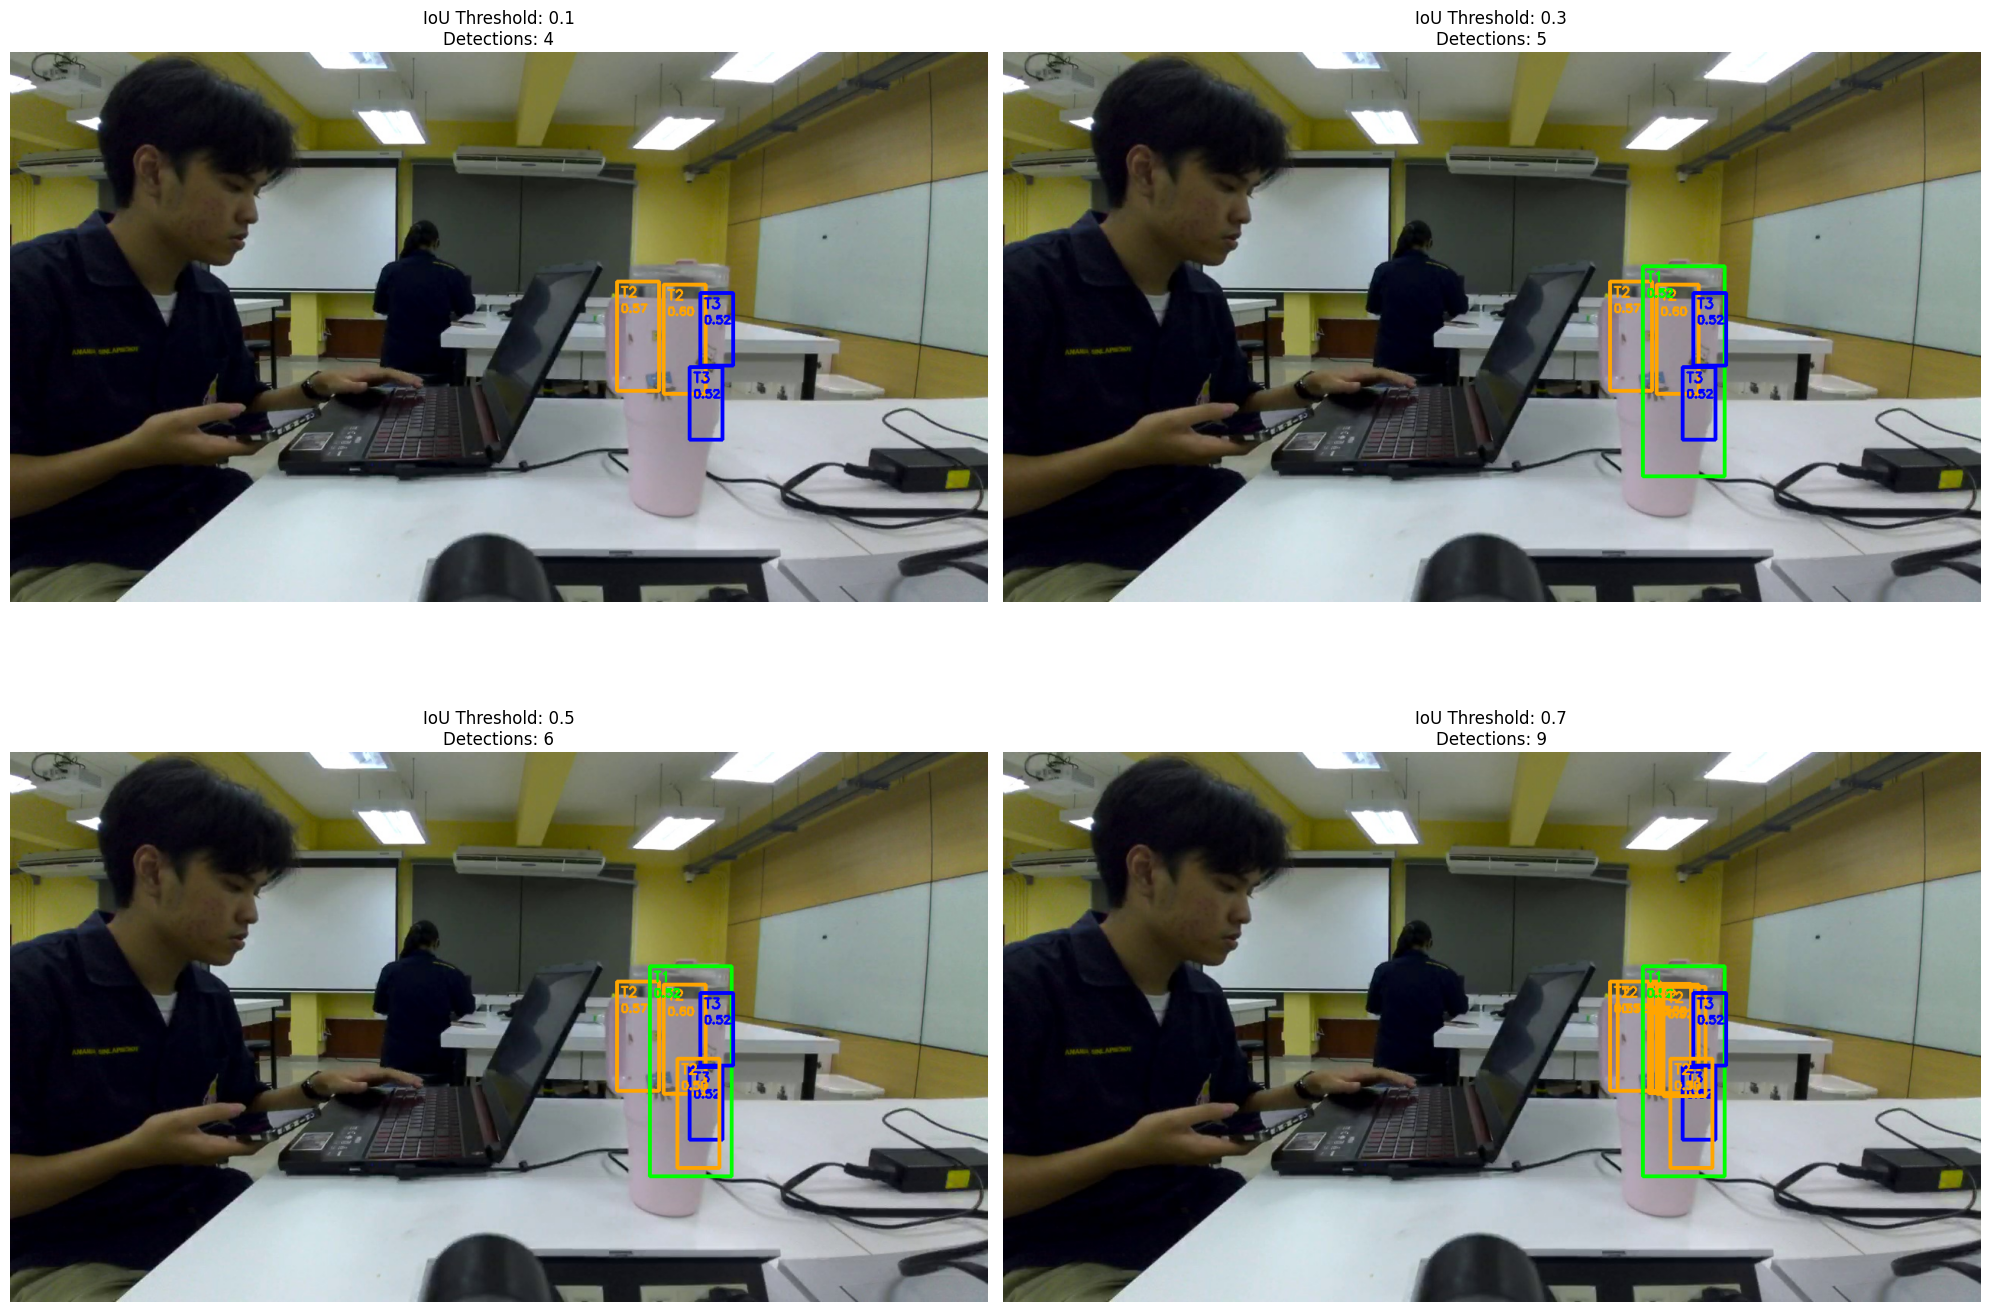

=== IoU Threshold Comparison ===
IoU 0.1: 4 detections
IoU 0.3: 5 detections
IoU 0.5: 6 detections
IoU 0.7: 9 detections


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลักและแปลงเป็น RGB
# ------------------------------
image = cv2.imread("../../../image/capture_test.jpg")
if image is None:
    raise FileNotFoundError("main_image.jpg not found")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ------------------------------
# 2. ฟังก์ชันสร้าง Pink Mask (ปรับปรุงจาก detect_object.ipynb)
# ------------------------------
def create_pink_mask(img_rgb):
    """สร้าง mask สำหรับสีชมพู โดยใช้ HSV color space"""
    # แปลงเป็น HSV เพื่อจับสีชมพูได้ดีกว่า
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # ช่วงค่าต่ำสุด ของสีชมพู (ปรับจาก detect_object.ipynb)
    lower_pink = np.array([120, 10, 100])
    # ช่วงค่าสูงสุด ของสีชมพู
    upper_pink = np.array([170, 100, 200])
    
    # สร้าง mask
    mask = cv2.inRange(hsv, lower_pink, upper_pink)
    
    # เพิ่มการ morphology เพื่อลด noise (จาก detect_object.ipynb)
    mask = cv2.medianBlur(mask, 7)
    kernel = np.ones((7, 7), np.uint8)
    # ปิดช่องว่างเล็กๆ
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# สร้าง pink mask สำหรับภาพหลัก
main_pink_mask = create_pink_mask(image_rgb)

# แปลงภาพหลักเป็น grayscale และใช้ mask
main_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
main_masked = cv2.bitwise_and(main_gray, main_gray, mask=main_pink_mask)

# ------------------------------
# 3. โหลด template และเตรียม mask + grayscale
# ------------------------------
template1 = "../../../image/template/template_night_pic1_x_557_y_266_w_107_h_275.jpg"
template2 = "../../../image/template/template_night_pic2_x_607_y_281_w_55_h_143.jpg"
template3 = "../../../image/template/template_night_pic4_x_318_y_146_w_17_h_38.jpg"

template_files = [template1, template2, template3]
templates_masked = []
templates_rgb = []
templates_masks = []

for f in template_files:
    tmpl = cv2.imread(f)
    if tmpl is None:
        raise FileNotFoundError(f"{f} not found")
    
    tmpl_rgb = cv2.cvtColor(tmpl, cv2.COLOR_BGR2RGB)
    templates_rgb.append(tmpl_rgb)
    
    # สร้าง pink mask สำหรับ template
    tmpl_pink_mask = create_pink_mask(tmpl_rgb)
    templates_masks.append(tmpl_pink_mask)
    
    # แปลงเป็น grayscale และใช้ mask
    tmpl_gray = cv2.cvtColor(tmpl_rgb, cv2.COLOR_RGB2GRAY)
    tmpl_masked = cv2.bitwise_and(tmpl_gray, tmpl_gray, mask=tmpl_pink_mask)
    
    templates_masked.append(tmpl_masked)

# ------------------------------
# 4. ฟังก์ชันทำ Template Matching สำหรับ masked grayscale
# ------------------------------
def match_template_masked(img_masked, tmpl_masked, threshold=0.8):
    """Template matching บน masked grayscale images"""
    result = cv2.matchTemplate(img_masked, tmpl_masked, cv2.TM_CCOEFF_NORMED)
    
    # หา location ที่ score >= threshold
    locations = np.where(result >= threshold)
    
    boxes = []
    h, w = tmpl_masked.shape
    
    for pt in zip(*locations[::-1]):  # แปลง (row, col) -> (x, y)
        boxes.append((pt, (pt[0]+w, pt[1]+h)))
    
    return boxes, result

# ------------------------------
# 5 .ทำ matching สำหรับทุก template - แก้ไขการวาดข้อความ

# ------------------------------
threshold = 0.5
matched_results = []

for i, tmpl_masked in enumerate(templates_masked):
    boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
    
    # วาดกรอบบนภาพต้นฉบับ (RGB)
    img_copy = image_rgb.copy()
    for j, (top_left, bottom_right) in enumerate(boxes):
        # วาดกรอบสีเขียว
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
        
        # คำนวณตำแหน่งข้อความให้ไม่ล้นออกนอกภาพ
        text_x = max(5, top_left[0])  # ไม่ให้ติดขอบซ้าย
        text_y = max(25, top_left[1] - 5)  # ไม่ให้ติดขอบบน
        
        # ตรวจสอบว่าข้อความจะล้นออกขวาหรือไม่
        img_height, img_width = img_copy.shape[:2]
        if text_x > img_width - 50:  # ถ้าใกล้ขอบขวา
            text_x = bottom_right[0] - 50
        
        # วาดข้อความด้วยสีเหลือง (ไม่ใช่แดง) และเพิ่ม background
        # วาดพื้นหลังสีดำให้ข้อความ
        cv2.rectangle(img_copy, (text_x-2, text_y-18), (text_x+35, text_y+2), (0, 0, 0), -1)
        # วาดข้อความสีเหลือง
        cv2.putText(img_copy, f"T{i+1}", (text_x, text_y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        
        # เพิ่มข้อมูล confidence score (ถ้าต้องการ)
        if j == 0:  # แสดงเฉพาะตัวแรก
            conf_y = text_y + 15
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            cv2.rectangle(img_copy, (text_x-2, conf_y-12), (text_x+60, conf_y+2), (0, 0, 0), -1)
            cv2.putText(img_copy, f"{confidence:.2f}", (text_x, conf_y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
    
    matched_results.append((img_copy, templates_rgb[i], len(boxes)))

# ------------------------------
# 6. แสดงผลด้วย subplot (เพิ่ม mask visualization)
# ------------------------------
plt.figure(figsize=(20, 16))

# แถวที่ 1: Templates
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1)
    plt.imshow(tmpl_res)
    plt.title(f"Template {i+1}")
    plt.axis("off")

# แถวที่ 2: Template masks
for i, tmpl_mask in enumerate(templates_masks):
    plt.subplot(5, len(matched_results), i+1+len(matched_results))
    plt.imshow(tmpl_mask, cmap='gray')
    plt.title(f"Template {i+1} Pink Mask")
    plt.axis("off")

# แถวที่ 3: Template masked (grayscale with mask applied)
for i, tmpl_masked in enumerate(templates_masked):
    plt.subplot(5, len(matched_results), i+1+2*len(matched_results))
    plt.imshow(tmpl_masked, cmap='gray')
    plt.title(f"Template {i+1} Masked")
    plt.axis("off")

# แถวที่ 4: Main image mask (แสดงเฉพาะรูปแรก)
plt.subplot(5, len(matched_results), 1+3*len(matched_results))
plt.imshow(main_pink_mask, cmap='gray')
plt.title("Main Image Pink Mask")
plt.axis("off")

plt.subplot(5, len(matched_results), 2+3*len(matched_results))
plt.imshow(main_masked, cmap='gray')
plt.title("Main Image Masked")
plt.axis("off")

# แถวที่ 5: ผล matching บนภาพ
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1+4*len(matched_results))
    plt.imshow(img_res)
    plt.title(f"Matches: {n_boxes}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ------------------------------
# 7. แสดงผลสรุป
# ------------------------------
print("=== Template Matching with Pink Mask Results ===")
for i, (_, _, n_boxes) in enumerate(matched_results):
    print(f"Template {i+1}: พบ {n_boxes} ตำแหน่ง")

print(f"\nThreshold ที่ใช้: {threshold}")
print("Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา")
print("ช่วยลด false positive และเพิ่มความแม่นยำในการ matching")

# ------------------------------
# 8. ฟังก์ชันเพิ่มเติม: แสดงรายละเอียดการตรวจจับ
# ------------------------------
def show_detection_details():
    """แสดงรายละเอียดของการตรวจจับแต่ละ template"""
    print("\n=== Detection Details ===")
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        if len(boxes) > 0:
            print(f"\nTemplate {i+1}:")
            for j, (top_left, bottom_right) in enumerate(boxes):
                x, y = top_left
                w = bottom_right[0] - top_left[0]
                h = bottom_right[1] - top_left[1]
                print(f"  Detection {j+1}: x={x}, y={y}, w={w}, h={h}")
                
                # คำนวณ confidence score ที่ตำแหน่งนั้น
                confidence = result[y, x] if y < result.shape[0] and x < result.shape[1] else 0
                print(f"    Confidence: {confidence:.3f}")
        else:
            print(f"\nTemplate {i+1}: ไม่พบการตรวจจับ")

show_detection_details()

# ------------------------------
# 9. Non-Maximum Suppression (NMS) เพื่อลดการทับซ้อน
# ------------------------------
def calculate_iou(box1, box2):
    """คำนวณ Intersection over Union (IoU) ระหว่าง 2 กรอบ"""
    # box format: ((x1, y1), (x2, y2))
    x1_1, y1_1 = box1[0]
    x2_1, y2_1 = box1[1]
    x1_2, y1_2 = box2[0]
    x2_2, y2_2 = box2[1]
    
    # หาพื้นที่ทับซ้อน (intersection)
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection_area = (x2_i - x1_i) * (y2_i - y1_i)
    
    # หาพื้นที่รวม (union)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - intersection_area
    
    return intersection_area / union_area if union_area > 0 else 0.0

def non_maximum_suppression(boxes_with_scores, iou_threshold=0.5):
    """Non-Maximum Suppression เพื่อกำจัดกรอบที่ทับซ้อน"""
    if len(boxes_with_scores) == 0:
        return []
    
    # เรียงตาม confidence score (จากมากไปน้อย)
    boxes_with_scores.sort(key=lambda x: x[2], reverse=True)
    
    selected_boxes = []
    
    while len(boxes_with_scores) > 0:
        # เลือกกรอบที่มี confidence สูงสุด
        current_box = boxes_with_scores.pop(0)
        selected_boxes.append(current_box)
        
        # กำจัดกรอบที่มี IoU สูงเกินไปกับกรอบที่เลือก
        boxes_with_scores = [
            box for box in boxes_with_scores
            if calculate_iou(current_box[:2], box[:2]) < iou_threshold
        ]
    
    return selected_boxes

def apply_nms_to_all_templates(iou_threshold=0.3):
    """ใช้ NMS กับผลลัพธ์จากทุก template"""
    all_detections = []
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]  # เขียว, ส้ม, น้ำเงิน
    
    # รวบรวมการตรวจจับทั้งหมด
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        for box in boxes:
            top_left, bottom_right = box
            # คำนวณ confidence score
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            
            # เก็บข้อมูล: (top_left, bottom_right, confidence, template_id, color)
            all_detections.append((top_left, bottom_right, confidence, i+1, colors[i % len(colors)]))
    
    # ใช้ NMS กับการตรวจจับทั้งหมด
    nms_detections = non_maximum_suppression(all_detections, iou_threshold)
    
    return nms_detections

# ------------------------------
# 10. สร้างภาพผลลัพธ์ที่ผ่าน NMS
# ------------------------------
def create_final_result_images(iou_threshold=0.3):
    """สร้างภาพเปรียบเทียบก่อนและหลัง NMS"""
    
    # ภาพก่อน NMS (ทับซ้อนกัน)
    img_before = image_rgb.copy()
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]
    total_boxes_before = 0
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        total_boxes_before += len(boxes)
        
        for top_left, bottom_right in boxes:
            color = colors[i % len(colors)]
            cv2.rectangle(img_before, top_left, bottom_right, color, 2)
            # เพิ่มหมายเลข template
            cv2.putText(img_before, f"T{i+1}", 
                       (top_left[0]+5, top_left[1]+20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # ภาพหลัง NMS (ไม่ทับซ้อน)
    img_after = image_rgb.copy()
    nms_detections = apply_nms_to_all_templates(iou_threshold)
    
    for detection in nms_detections:
        top_left, bottom_right, confidence, template_id, color = detection
        
        # วาดกรอบ
        cv2.rectangle(img_after, top_left, bottom_right, color, 3)
        
        # วาดข้อความ template ID
        cv2.putText(img_after, f"T{template_id}", 
                   (top_left[0]+5, top_left[1]+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # วาด confidence score
        cv2.putText(img_after, f"{confidence:.2f}", 
                   (top_left[0]+5, top_left[1]+40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_before, img_after, total_boxes_before, len(nms_detections)

# สร้างภาพเปรียบเทียบ
img_before_nms, img_after_nms, count_before, count_after = create_final_result_images(iou_threshold=0.3)

# แสดงผลเปรียบเทียบ
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_before_nms)
plt.title(f"Before NMS\nTotal Detections: {count_before}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_after_nms)
plt.title(f"After NMS (IoU threshold: 0.3)\nFinal Detections: {count_after}")
plt.axis('off')

plt.tight_layout()
plt.show()

# ------------------------------
# 11. แสดงรายละเอียดการทำ NMS
# ------------------------------
def show_nms_details():
    """แสดงรายละเอียดของ NMS process"""
    print("=== Non-Maximum Suppression Details ===")
    
    nms_detections = apply_nms_to_all_templates(iou_threshold=0.3)
    
    print(f"IoU Threshold: 0.3")
    print(f"Detections before NMS: {count_before}")
    print(f"Detections after NMS: {count_after}")
    print(f"Removed overlapping boxes: {count_before - count_after}")
    
    print(f"\n=== Final Detection Results ===")
    for i, detection in enumerate(nms_detections):
        top_left, bottom_right, confidence, template_id, color = detection
        x, y = top_left
        w = bottom_right[0] - top_left[0]
        h = bottom_right[1] - top_left[1]
        
        print(f"Detection {i+1}: Template T{template_id}")
        print(f"  Position: x={x}, y={y}, w={w}, h={h}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  Color: {color}")

show_nms_details()

# ------------------------------
# 12. ทดสอบ IoU threshold ต่างๆ
# ------------------------------
def compare_iou_thresholds():
    """เปรียบเทียบผลลัพธ์ที่ IoU threshold ต่างๆ"""
    thresholds = [0.1, 0.3, 0.5, 0.7]
    
    plt.figure(figsize=(20, 15))
    
    for i, iou_thresh in enumerate(thresholds):
        _, img_result, _, final_count = create_final_result_images(iou_thresh)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img_result)
        plt.title(f"IoU Threshold: {iou_thresh}\nDetections: {final_count}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("=== IoU Threshold Comparison ===")
    for iou_thresh in thresholds:
        nms_result = apply_nms_to_all_templates(iou_thresh)
        print(f"IoU {iou_thresh}: {len(nms_result)} detections")

compare_iou_thresholds()

# 1. โหลดภาพหลักและแปลงเป็น RGB


    เป็นขั้นตอนแรกของการประมวลผลภาพ
1. โหลดไฟล์ภาพ

image = cv2.imread("../../../image/capture_test.jpg") ใช้ไลบรารี OpenCV (cv2) เพื่อโหลดไฟล์ภาพที่ชื่อ capture_test.jpg จากตำแหน่งที่กำหนดในคอมพิวเตอร์ครับ ถ้าหาไฟล์ไม่เจอ cv2.imread() จะคืนค่าเป็น None

2. ตรวจสอบความถูกต้องของไฟล์

if image is None: raise FileNotFoundError("main_image.jpg not found") เป็นการตรวจสอบว่าการโหลดภาพสำเร็จหรือไม่ ถ้า image เป็น None ก็แสดงว่าหาไฟล์ไม่เจอ โค้ดก็จะหยุดทำงานและแจ้งข้อผิดพลาดให้ทราบครับ

3. แปลงสีของภาพ

โดยปกติแล้ว OpenCV จะโหลดภาพในรูปแบบสีแบบ BGR (Blue, Green, Red) ซึ่งเป็นลำดับสีที่ต่างจากที่เราคุ้นเคยกันในไลบรารีอื่นๆ เช่น Matplotlib ที่ใช้รูปแบบสีแบบ RGB (Red, Green, Blue) การแปลงสีจาก BGR เป็น RGB ด้วย cv2.cvtColor(image, cv2.COLOR_BGR2RGB) จึงจำเป็นเพื่อให้การแสดงผลภาพด้วย Matplotlib ในภายหลังถูกต้องครับ



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. โหลดภาพหลักและแปลงเป็น RGB
# ------------------------------
image = cv2.imread("../../../image/capture_test.jpg")
if image is None:
    raise FileNotFoundError("main_image.jpg not found")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2. ฟังก์ชันสร้าง Pink Mask (ปรับปรุงจาก detect_object.ipynb)


ฟังก์ชัน create_pink_mask()

    มีไว้สำหรับสร้าง "มาสก์" (Mask) หรือหน้ากากที่ระบุตำแหน่งของสีชมพูในภาพ หลักการคือ
1. แปลงสีภาพ
 ฟังก์ชันจะรับภาพในรูปแบบ RGB เข้ามา จากนั้นจะแปลงให้เป็นรูปแบบสี BGR และสุดท้ายแปลงเป็น HSV (Hue, Saturation, Value) เหตุผลที่ใช้ HSV เพราะการระบุสีในรูปแบบนี้จะง่ายกว่าและแม่นยำกว่า RGB มาก โดยค่า Hue จะใช้บอกชนิดของสี (เช่น แดง, เหลือง, ชมพู), Saturation บอกความอิ่มตัวของสี และ Value บอกความสว่างของสี
2. กำหนดช่วงสี
โค้ดจะกำหนดช่วงค่า HSV ที่เป็นสีชมพู โดยใช้ lower_pink และ upper_pink เพื่อระบุขอบเขตของสีที่ต้องการ
3. สร้างมาสก์
คำสั่ง cv2.inRange() จะสร้างภาพไบนารี (Binary Image) หรือมาสก์ขึ้นมา โดยพิกเซลที่เป็นสีชมพูตามช่วงที่กำหนดจะมีค่าเป็นสีขาว (255) ส่วนพิกเซลอื่นๆ จะมีค่าเป็นสีดำ (0)
4. ลด Noise
มาสก์ที่ได้จาก cv2.inRange() อาจมีจุดรบกวน (Noise) หรือช่องว่างเล็ก ๆ cv2.medianBlur() จะช่วยลด Noise และ cv2.morphologyEx() จะช่วยเติมเต็มช่องว่างเล็ก ๆ ในมาสก์ ทำให้มาสก์มีความสมบูรณ์มากขึ้น

In [ ]:
def create_pink_mask(img_rgb):
    """สร้าง mask สำหรับสีชมพู โดยใช้ HSV color space"""
    # แปลงเป็น HSV เพื่อจับสีชมพูได้ดีกว่า
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # ช่วงค่าต่ำสุด ของสีชมพู (ปรับจาก detect_object.ipynb)
    lower_pink = np.array([120, 10, 100])
    # ช่วงค่าสูงสุด ของสีชมพู
    upper_pink = np.array([170, 100, 200])
    
    # สร้าง mask
    mask = cv2.inRange(hsv, lower_pink, upper_pink)
    
    # เพิ่มการ morphology เพื่อลด noise (จาก detect_object.ipynb)
    mask = cv2.medianBlur(mask, 7)
    kernel = np.ones((7, 7), np.uint8)
    # ปิดช่องว่างเล็กๆ
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# 3. โหลด template และเตรียม mask + grayscale


โหลด template และเตรียม mask + grayscale

    ทำหน้าที่คล้ายกับ ฟังก์ชัน create_pink_mask() แต่ทำซ้ำสำหรับแต่ละ Template ที่ต้องการใช้ค้นหา
1. วนลูปโหลด Template
โค้ดจะวนลูปผ่านรายการไฟล์รูปภาพ Template (template_files) ที่เตรียมไว้
2. เตรียม Template แต่ละรูป
สำหรับ Template แต่ละรูป โค้ดจะ
- โหลดภาพ Template
- แปลงภาพจาก BGR เป็น RGB
- ใช้ฟังก์ชัน create_pink_mask() ที่สร้างไว้ในส่วนที่ 2 เพื่อสร้างมาสก์สีชมพูสำหรับ Template
- แปลงภาพ Template เป็นสีเทา (tmpl_gray)
- นำมาสก์ที่ได้มาใช้กับภาพสีเทาด้วย cv2.bitwise_and() เพื่อให้ได้ภาพ Template ที่มีเฉพาะส่วนที่เป็นสีชมพูเท่านั้น (tmpl_masked)

ผลลัพธ์ที่ได้คือรายการของภาพ Template ที่ผ่านการมาสก์แล้ว (templates_masked) ซึ่งพร้อมสำหรับการนำไปเปรียบเทียบกับภาพหลักที่ผ่านการมาสก์แล้ว (main_masked) ในขั้นตอน Template Matching ถัดไป

In [ ]:
template1 = "../../../image/template/template_night_pic1_x_557_y_266_w_107_h_275.jpg"
template2 = "../../../image/template/template_night_pic2_x_607_y_281_w_55_h_143.jpg"
template3 = "../../../image/template/template_night_pic4_x_318_y_146_w_17_h_38.jpg"

template_files = [template1, template2, template3]
templates_masked = []
templates_rgb = []
templates_masks = []

for f in template_files:
    tmpl = cv2.imread(f)
    if tmpl is None:
        raise FileNotFoundError(f"{f} not found")
    
    tmpl_rgb = cv2.cvtColor(tmpl, cv2.COLOR_BGR2RGB)
    templates_rgb.append(tmpl_rgb)
    
    # สร้าง pink mask สำหรับ template
    tmpl_pink_mask = create_pink_mask(tmpl_rgb)
    templates_masks.append(tmpl_pink_mask)
    
    # แปลงเป็น grayscale และใช้ mask
    tmpl_gray = cv2.cvtColor(tmpl_rgb, cv2.COLOR_RGB2GRAY)
    tmpl_masked = cv2.bitwise_and(tmpl_gray, tmpl_gray, mask=tmpl_pink_mask)
    
    templates_masked.append(tmpl_masked)

# 4. ฟังก์ชันทำ Template Matching สำหรับ masked grayscale


ฟังก์ชัน match_template_masked()

ขั้นตอนการทำงานหลักๆ
1. การเปรียบเทียบภาพ (Template Matching)
- result = cv2.matchTemplate(img_masked, tmpl_masked, cv2.TM_CCOEFF_NORMED): คำสั่งนี้คือหัวใจหลักของฟังก์ชัน มันจะนำภาพหลักที่ผ่านการมาสก์แล้ว (img_masked) มาเปรียบเทียบกับภาพ Template ที่ผ่านการมาสก์แล้ว (tmpl_masked) โดยใช้เทคนิค cv2.TM_CCOEFF_NORMED
- cv2.TM_CCOEFF_NORMED เป็นหนึ่งในวิธีการคำนวณความคล้ายคลึงกันระหว่างภาพและ Template โดยให้ค่าความสัมพันธ์อยู่ในช่วง -1 ถึง 1
    - ค่าเข้าใกล้ 1: หมายถึงภาพสองส่วนนั้นมีความคล้ายคลึงกันมากที่สุด (การจับคู่สมบูรณ์แบบ)
    - ค่าเข้าใกล้ 0: หมายถึงไม่มีความสัมพันธ์กันเลย
    - ค่าเข้าใกล้ -1: หมายถึงความสัมพันธ์ในเชิงตรงกันข้าม

ผลลัพธ์ที่ได้ (result) คือภาพ 2 มิติ (คล้ายกับแผนที่ความร้อน) ที่แต่ละพิกเซลมีค่าความสัมพันธ์ (correlation score) บอกว่าตำแหน่งนั้นๆ ในภาพหลักมีความคล้ายคลึงกับ Template มากแค่ไหน
2. การหาตำแหน่งที่ตรงกัน
- locations = np.where(result >= threshold): โค้ดนี้จะค้นหาตำแหน่งทั้งหมดบนแผนที่ result ที่มีค่าความสัมพันธ์ สูงกว่าหรือเท่ากับค่า threshold ที่เรากำหนดไว้ (ในที่นี้คือ 0.8)
- ค่า threshold นี้เป็นตัวกำหนดว่าเรายอมรับการจับคู่ที่ "คล้าย" กันมากแค่ไหน ยิ่งค่าสูง การจับคู่ก็จะยิ่งเข้มงวดมากขึ้น
- np.where() จะคืนค่าเป็น tuple ของ arrays ที่เก็บพิกัดแถว (row) และคอลัมน์ (col) ของทุกตำแหน่งที่ตรงตามเงื่อนไข
3. การสร้างกรอบสี่เหลี่ยม (Bounding Boxes)
- for pt in zip(*locations[::-1]): ลูปนี้จะวนผ่านทุกพิกัดที่พบจากการค้นหาในขั้นตอนที่แล้ว. locations[::-1] เป็นการสลับลำดับจาก (แถว, คอลัมน์) ให้เป็น (คอลัมน์, แถว) เพื่อให้ตรงกับรูปแบบ (x, y) ที่นิยมใช้ในการวาดกรอบ
- boxes.append((pt, (pt[0]+w, pt[1]+h))): สำหรับแต่ละพิกัด pt (ซึ่งคือมุมซ้ายบนของกรอบ) โค้ดจะคำนวณพิกัดของมุมขวาล่างโดยการเพิ่มความกว้าง (w) และความสูง (h) ของ Template เข้าไป จากนั้นจึงเก็บข้อมูลกรอบสี่เหลี่ยมทั้งหมดไว้ในรายการ boxes

ฟังก์ชันนี้รับภาพที่ผ่านการมาสก์แล้วทั้งสองภาพ (ภาพหลักและ Template) จากนั้นนำมาเปรียบเทียบเพื่อสร้างแผนที่คะแนนความคล้ายคลึงกัน แล้วจึงค้นหาทุกตำแหน่งบนแผนที่ที่มีคะแนนสูงพอ (มากกว่า threshold) เพื่อสร้างเป็นกรอบสี่เหลี่ยม (Bounding Boxes) ที่ระบุตำแหน่งที่คาดว่าวัตถุเป้าหมายอยู่ในภาพหลัก

In [ ]:
def match_template_masked(img_masked, tmpl_masked, threshold=0.8):
    """Template matching บน masked grayscale images"""
    result = cv2.matchTemplate(img_masked, tmpl_masked, cv2.TM_CCOEFF_NORMED)
    
    # หา location ที่ score >= threshold
    locations = np.where(result >= threshold)
    
    boxes = []
    h, w = tmpl_masked.shape
    
    for pt in zip(*locations[::-1]):  # แปลง (row, col) -> (x, y)
        boxes.append((pt, (pt[0]+w, pt[1]+h)))
    
    return boxes, result

# 5. ทำ matching สำหรับทุก template - แก้ไขการวาดข้อความ 

การทำ Template Matching และวาดผลลัพธ์

จะวนลูปเพื่อนำ Template แต่ละตัวมาจับคู่กับภาพหลัก แล้ววาดกรอบสี่เหลี่ยม (bounding box) ที่ตรวจจับได้ลงบนภาพต้นฉบับ
- ลูปสำหรับแต่ละ Template: โค้ดจะวนลูปผ่านรายการ templates_masked เพื่อจับคู่ Template แต่ละตัวกับ main_masked โดยใช้ฟังก์ชัน match_template_masked และใช้ค่า threshold = 0.5
- การวาดกรอบและข้อความ: เมื่อได้ตำแหน่งที่ตรวจจับได้ (ในตัวแปร boxes) โค้ดจะสร้างสำเนาของภาพต้นฉบับ (img_copy) และวนลูปวาดกรอบสี่เหลี่ยมสีเขียว ((0, 255, 0)) พร้อมกับข้อความระบุหมายเลข Template (T1, T2, T3) ลงไป นอกจากนี้ยังมีการเพิ่มพื้นหลังสีดำและวาดค่าความเชื่อมั่น (confidence score) สำหรับการตรวจจับแรกด้วย

In [ ]:
threshold = 0.5
matched_results = []

for i, tmpl_masked in enumerate(templates_masked):
    boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
    
    # วาดกรอบบนภาพต้นฉบับ (RGB)
    img_copy = image_rgb.copy()
    for j, (top_left, bottom_right) in enumerate(boxes):
        # วาดกรอบสีเขียว
        cv2.rectangle(img_copy, top_left, bottom_right, (0, 255, 0), 2)
        
        # คำนวณตำแหน่งข้อความให้ไม่ล้นออกนอกภาพ
        text_x = max(5, top_left[0])  # ไม่ให้ติดขอบซ้าย
        text_y = max(25, top_left[1] - 5)  # ไม่ให้ติดขอบบน
        
        # ตรวจสอบว่าข้อความจะล้นออกขวาหรือไม่
        img_height, img_width = img_copy.shape[:2]
        if text_x > img_width - 50:  # ถ้าใกล้ขอบขวา
            text_x = bottom_right[0] - 50
        
        # วาดข้อความด้วยสีเหลือง (ไม่ใช่แดง) และเพิ่ม background
        # วาดพื้นหลังสีดำให้ข้อความ
        cv2.rectangle(img_copy, (text_x-2, text_y-18), (text_x+35, text_y+2), (0, 0, 0), -1)
        # วาดข้อความสีเหลือง
        cv2.putText(img_copy, f"T{i+1}", (text_x, text_y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        
        # เพิ่มข้อมูล confidence score (ถ้าต้องการ)
        if j == 0:  # แสดงเฉพาะตัวแรก
            conf_y = text_y + 15
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            cv2.rectangle(img_copy, (text_x-2, conf_y-12), (text_x+60, conf_y+2), (0, 0, 0), -1)
            cv2.putText(img_copy, f"{confidence:.2f}", (text_x, conf_y-2), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
    
    matched_results.append((img_copy, templates_rgb[i], len(boxes)))

# 6. แสดงผลด้วย subplot (เพิ่ม mask visualization) 

การแสดงผลด้วยกราฟและรูปภาพ 

    ใช้ไลบรารี Matplotlib เพื่อแสดงผลลัพธ์ทั้งหมดในรูปแบบที่เข้าใจง่าย โดยจัดเรียงเป็นหลายแถว (Subplots)
- แถวที่ 1-3
แสดงภาพ Template ที่ใช้ในการค้นหา, ภาพมาสก์สีชมพูของ Template, และภาพ Template ที่ผ่านการมาสก์และแปลงเป็น Grayscale แล้ว ซึ่งช่วยให้เราเห็นว่าภาพ Template ที่ใช้ในการค้นหาจริง ๆ มีลักษณะอย่างไร
- แถวที่ 4
แสดงภาพมาสก์สีชมพูของภาพหลัก และภาพภาพหลักที่ผ่านการมาสก์แล้ว ทำให้เห็นว่าโค้ดมุ่งเน้นการค้นหาในส่วนไหนของภาพ
- แถวที่ 5
แสดงผลลัพธ์สุดท้ายบนภาพหลัก โดยมีกรอบสีเขียวล้อมรอบจุดที่ตรวจจับได้ แต่ละรูปในแถวนี้จะแสดงผลลัพธ์สำหรับ Template แต่ละตัว พร้อมระบุจำนวนที่ตรวจจับได้ในหัวข้อ (Matches: n)

In [ ]:
plt.figure(figsize=(20, 16))

# แถวที่ 1: Templates
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1)
    plt.imshow(tmpl_res)
    plt.title(f"Template {i+1}")
    plt.axis("off")

# แถวที่ 2: Template masks
for i, tmpl_mask in enumerate(templates_masks):
    plt.subplot(5, len(matched_results), i+1+len(matched_results))
    plt.imshow(tmpl_mask, cmap='gray')
    plt.title(f"Template {i+1} Pink Mask")
    plt.axis("off")

# แถวที่ 3: Template masked (grayscale with mask applied)
for i, tmpl_masked in enumerate(templates_masked):
    plt.subplot(5, len(matched_results), i+1+2*len(matched_results))
    plt.imshow(tmpl_masked, cmap='gray')
    plt.title(f"Template {i+1} Masked")
    plt.axis("off")

# แถวที่ 4: Main image mask (แสดงเฉพาะรูปแรก)
plt.subplot(5, len(matched_results), 1+3*len(matched_results))
plt.imshow(main_pink_mask, cmap='gray')
plt.title("Main Image Pink Mask")
plt.axis("off")

plt.subplot(5, len(matched_results), 2+3*len(matched_results))
plt.imshow(main_masked, cmap='gray')
plt.title("Main Image Masked")
plt.axis("off")

# แถวที่ 5: ผล matching บนภาพ
for i, (img_res, tmpl_res, n_boxes) in enumerate(matched_results):
    plt.subplot(5, len(matched_results), i+1+4*len(matched_results))
    plt.imshow(img_res)
    plt.title(f"Matches: {n_boxes}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 7. แสดงผลสรุป

การแสดงผลลัพธ์แบบข้อความ

จะแสดงผลสรุปและรายละเอียดการตรวจจับในหน้าจอคอนโซล
- สรุปผล: โค้ดจะพิมพ์ข้อความสรุปว่าแต่ละ Template พบการตรวจจับกี่ตำแหน่ง และเน้นย้ำว่าการใช้ Pink Mask ช่วยลด "false positive" (การตรวจจับที่ผิดพลาด) และเพิ่มความแม่นยำได้อย่างไร
- รายละเอียดการตรวจจับ: ฟังก์ชัน show_detection_details() จะถูกเรียกใช้เพื่อแสดงรายละเอียดเพิ่มเติมสำหรับแต่ละกรอบที่ตรวจจับได้ เช่น พิกัด (x, y) ความกว้าง (w) ความสูง (h) และค่าความเชื่อมั่น (confidence) ซึ่งเป็นข้อมูลเชิงลึกที่มีประโยชน์ในการวิเคราะห์ผลลัพธ์

In [ ]:
print("=== Template Matching with Pink Mask Results ===")
for i, (_, _, n_boxes) in enumerate(matched_results):
    print(f"Template {i+1}: พบ {n_boxes} ตำแหน่ง")

print(f"\nThreshold ที่ใช้: {threshold}")
print("Pink mask ถูกใช้เพื่อมุ่งเน้นเฉพาะพื้นที่สีชมพูในการค้นหา")
print("ช่วยลด false positive และเพิ่มความแม่นยำในการ matching")

# 8. ฟังก์ชันเพิ่มเติม แสดงรายละเอียดการตรวจจับ

ฟังก์ชัน show_detection_details มีวัตถุประสงค์เพื่อแสดงข้อมูลเชิงลึกของการตรวจจับแต่ละครั้งที่โปรแกรมพบ

- การวนลูป
โค้ดจะวนลูปผ่าน Template แต่ละตัวอีกครั้ง เพื่อนำผลลัพธ์ boxes และ result มาใช้ในการแสดงข้อมูล
- แสดงข้อมูล
 ถ้ามีการตรวจจับได้ (len(boxes) > 0) โปรแกรมจะพิมพ์รายละเอียดของแต่ละกรอบที่พบออกมาในรูปแบบที่อ่านง่าย
- ข้อมูลที่แสดง 
รายละเอียดที่แสดงประกอบด้วย
    - ตำแหน่ง (x, y): พิกัดของมุมซ้ายบนของกรอบสี่เหลี่ยม.
    - ขนาด (w, h): ความกว้างและความสูงของกรอบ.
    - ค่าความเชื่อมั่น (Confidence): ค่าความคล้ายคลึงที่ได้จากการทำ Template Matching ซึ่งยิ่งใกล้ 1 ยิ่งดี.


In [ ]:
def show_detection_details():
    """แสดงรายละเอียดของการตรวจจับแต่ละ template"""
    print("\n=== Detection Details ===")
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        if len(boxes) > 0:
            print(f"\nTemplate {i+1}:")
            for j, (top_left, bottom_right) in enumerate(boxes):
                x, y = top_left
                w = bottom_right[0] - top_left[0]
                h = bottom_right[1] - top_left[1]
                print(f"  Detection {j+1}: x={x}, y={y}, w={w}, h={h}")
                
                # คำนวณ confidence score ที่ตำแหน่งนั้น
                confidence = result[y, x] if y < result.shape[0] and x < result.shape[1] else 0
                print(f"    Confidence: {confidence:.3f}")
        else:
            print(f"\nTemplate {i+1}: ไม่พบการตรวจจับ")

show_detection_details()

# 9. Non-Maximum Suppression (NMS) เพื่อลดการทับซ้อน

    ใช้ แก้ปัญหาการตรวจจับซ้ำซ้อน เทคนิค Non-Maximum Suppression (NMS) คือกระบวนการที่คัดเลือกกรอบที่ดีที่สุดจากกลุ่มกรอบที่ทับซ้อนกันเพื่อกำจัดกรอบที่ไม่จำเป็นออกไป
ฟังก์ชัน calculate_iou (การคำนวณ IoU)
- oU ย่อมาจาก Intersection over Union เป็นตัวชี้วัดที่ใช้ประเมินว่ากรอบสี่เหลี่ยมสองอันทับซ้อนกันมากแค่ไหน
- หลักการ

หาพื้นที่ทับซ้อน (Intersection)คำนวณพื้นที่ของส่วนที่กรอบทั้งสองทับซ้อนกัน.

หาพื้นที่รวม (Union) คำนวณพื้นที่รวมทั้งหมดของกรอบทั้งสอง (พื้นที่ของกรอบ A + พื้นที่ของกรอบ B - พื้นที่ทับซ้อน).

คำนวณ IoU นำพื้นที่ทับซ้อนหารด้วยพื้นที่รวม ผลลัพธ์ที่ได้จะเป็นค่าระหว่าง 0 ถึง 1
- ค่า IoU

IoU = 0 ไม่มีพื้นที่ทับซ้อนกันเลย.

IoU = 1 กรอบทั้งสองซ้อนทับกันอย่างสมบูรณ์.

    ฟังก์ชันนี้จะถูกใช้ใน non_maximum_suppression เพื่อเป็นเกณฑ์ในการตัดสินใจว่าจะกำจัดกรอบไหนทิ้ง


ฟังก์ชัน non_maximum_suppression (NMS)
ขั้นตอนการทำงาน
- เรียงลำดับ เรียงกรอบสี่เหลี่ยมทั้งหมดตามค่าความเชื่อมั่น (confidence score) จากมากไปน้อย.
- เลือกกรอบที่ดีที่สุด เลือกกรอบแรกที่มีค่าความเชื่อมั่นสูงสุดออกมา.
- เปรียบเทียบและกำจัด เปรียบเทียบกรอบที่เลือกกับกรอบที่เหลือทั้งหมด. หากกรอบใดมีค่า IoU สูงกว่าค่า iou_threshold ที่กำหนดไว้ (หมายความว่าทับซ้อนกันมากเกินไป) ก็จะถูกกำจัดออกจากรายการ.
- ทำซ้ำ
ทำขั้นตอนที่ 2 และ 3 ซ้ำไปเรื่อย ๆ จนกว่าจะไม่มีกรอบเหลืออยู่ในรายการ


ฟังก์ชัน apply_nms_to_all_templates
    ฟังก์ชันนี้ทำหน้าที่รวบรวมผลลัพธ์การตรวจจับทั้งหมดจาก Template ทุกตัวเข้าด้วยกันก่อนที่จะนำไปใช้เทคนิค NMS.
- การรวบรวม
โค้ดจะวนลูปผ่าน Template แต่ละตัว เรียกใช้ match_template_masked เพื่อหาตำแหน่งที่ตรงกัน และเก็บข้อมูลของแต่ละการตรวจจับไว้ในรายการ all_detections ซึ่งประกอบด้วยตำแหน่ง, ค่าความเชื่อมั่น, หมายเลข Template และสีที่ใช้สำหรับวาดกรอบ.
- การประยุกต์ใช้ NMS
จากนั้นจะเรียกใช้ฟังก์ชัน non_maximum_suppression เพื่อกรองกรอบที่ทับซ้อนกันออกจากรายการ all_detections

In [ ]:
def calculate_iou(box1, box2):
    """คำนวณ Intersection over Union (IoU) ระหว่าง 2 กรอบ"""
    # box format: ((x1, y1), (x2, y2))
    x1_1, y1_1 = box1[0]
    x2_1, y2_1 = box1[1]
    x1_2, y1_2 = box2[0]
    x2_2, y2_2 = box2[1]
    
    # หาพื้นที่ทับซ้อน (intersection)
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0
    
    intersection_area = (x2_i - x1_i) * (y2_i - y1_i)
    
    # หาพื้นที่รวม (union)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - intersection_area
    
    return intersection_area / union_area if union_area > 0 else 0.0

def non_maximum_suppression(boxes_with_scores, iou_threshold=0.5):
    """Non-Maximum Suppression เพื่อกำจัดกรอบที่ทับซ้อน"""
    if len(boxes_with_scores) == 0:
        return []
    
    # เรียงตาม confidence score (จากมากไปน้อย)
    boxes_with_scores.sort(key=lambda x: x[2], reverse=True)
    
    selected_boxes = []
    
    while len(boxes_with_scores) > 0:
        # เลือกกรอบที่มี confidence สูงสุด
        current_box = boxes_with_scores.pop(0)
        selected_boxes.append(current_box)
        
        # กำจัดกรอบที่มี IoU สูงเกินไปกับกรอบที่เลือก
        boxes_with_scores = [
            box for box in boxes_with_scores
            if calculate_iou(current_box[:2], box[:2]) < iou_threshold
        ]
    
    return selected_boxes

def apply_nms_to_all_templates(iou_threshold=0.3):
    """ใช้ NMS กับผลลัพธ์จากทุก template"""
    all_detections = []
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]  # เขียว, ส้ม, น้ำเงิน
    
    # รวบรวมการตรวจจับทั้งหมด
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        
        for box in boxes:
            top_left, bottom_right = box
            # คำนวณ confidence score
            confidence = result[top_left[1], top_left[0]] if top_left[1] < result.shape[0] and top_left[0] < result.shape[1] else 0
            
            # เก็บข้อมูล: (top_left, bottom_right, confidence, template_id, color)
            all_detections.append((top_left, bottom_right, confidence, i+1, colors[i % len(colors)]))
    
    # ใช้ NMS กับการตรวจจับทั้งหมด
    nms_detections = non_maximum_suppression(all_detections, iou_threshold)
    
    return nms_detections


# 10. สร้างภาพผลลัพธ์ที่ผ่าน NMS

ฟังก์ชัน create_final_result_images
จะสร้างภาพสองภาพขึ้นมาเพื่อเปรียบเทียบกัน
- ภาพก่อน NMS (img_before)
โค้ดจะวนลูปเพื่อทำ Template Matching สำหรับ Template ทุกตัว และวาดกรอบสี่เหลี่ยมทั้งหมดที่ตรวจจับได้ลงบนภาพต้นฉบับ แม้ว่าหลายกรอบอาจจะทับซ้อนกันอยู่ก็ตาม
- ภาพหลัง NMS (img_after)
โค้ดจะเรียกใช้ฟังก์ชัน apply_nms_to_all_templates ที่ได้อธิบายไว้ก่อนหน้า เพื่อกรองเอากรอบที่ดีที่สุดและไม่ทับซ้อนกันออกมา จากนั้นจึงวาดเฉพาะกรอบเหล่านั้นลงบนภาพอีกภาพหนึ่ง

In [ ]:
def create_final_result_images(iou_threshold=0.3):
    """สร้างภาพเปรียบเทียบก่อนและหลัง NMS"""
    
    # ภาพก่อน NMS (ทับซ้อนกัน)
    img_before = image_rgb.copy()
    colors = [(0, 255, 0), (255, 165, 0), (0, 0, 255)]
    total_boxes_before = 0
    
    for i, tmpl_masked in enumerate(templates_masked):
        boxes, result = match_template_masked(main_masked, tmpl_masked, threshold)
        total_boxes_before += len(boxes)
        
        for top_left, bottom_right in boxes:
            color = colors[i % len(colors)]
            cv2.rectangle(img_before, top_left, bottom_right, color, 2)
            # เพิ่มหมายเลข template
            cv2.putText(img_before, f"T{i+1}", 
                       (top_left[0]+5, top_left[1]+20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # ภาพหลัง NMS (ไม่ทับซ้อน)
    img_after = image_rgb.copy()
    nms_detections = apply_nms_to_all_templates(iou_threshold)
    
    for detection in nms_detections:
        top_left, bottom_right, confidence, template_id, color = detection
        
        # วาดกรอบ
        cv2.rectangle(img_after, top_left, bottom_right, color, 3)
        
        # วาดข้อความ template ID
        cv2.putText(img_after, f"T{template_id}", 
                   (top_left[0]+5, top_left[1]+20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # วาด confidence score
        cv2.putText(img_after, f"{confidence:.2f}", 
                   (top_left[0]+5, top_left[1]+40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_before, img_after, total_boxes_before, len(nms_detections)

# สร้างภาพเปรียบเทียบ
img_before_nms, img_after_nms, count_before, count_after = create_final_result_images(iou_threshold=0.3)

# แสดงผลเปรียบเทียบ
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_before_nms)
plt.title(f"Before NMS\nTotal Detections: {count_before}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_after_nms)
plt.title(f"After NMS (IoU threshold: 0.3)\nFinal Detections: {count_after}")
plt.axis('off')

plt.tight_layout()
plt.show()

# 11. แสดงรายละเอียดการทำ NMS


ฟังก์ชัน show_nms_details
ทำหน้าที่แสดงข้อมูลสรุปเกี่ยวกับการทำงานของ NMS ในรูปแบบข้อความ
- สรุปจำนวน
โค้ดจะพิมพ์จำนวนการตรวจจับทั้งหมดที่พบก่อน NMS และจำนวนการตรวจจับสุดท้ายที่เหลืออยู่หลัง NMS เพื่อให้เห็นว่ามีกรอบที่ถูกกำจัดออกไปกี่กรอบ

- ข้อมูลสุดท้าย
จากนั้น โค้ดจะวนลูปแสดงรายละเอียดของแต่ละกรอบที่เหลืออยู่หลังการใช้ NMS ซึ่งรวมถึงพิกัด, ขนาด, และค่าความเชื่อมั่น ทำให้เราทราบได้อย่างแม่นยำว่ากรอบสุดท้ายที่โปรแกรมตัดสินใจเลือกคือกรอบไหนบ้าง

In [ ]:
def show_nms_details():
    """แสดงรายละเอียดของ NMS process"""
    print("=== Non-Maximum Suppression Details ===")
    
    nms_detections = apply_nms_to_all_templates(iou_threshold=0.3)
    
    print(f"IoU Threshold: 0.3")
    print(f"Detections before NMS: {count_before}")
    print(f"Detections after NMS: {count_after}")
    print(f"Removed overlapping boxes: {count_before - count_after}")
    
    print(f"\n=== Final Detection Results ===")
    for i, detection in enumerate(nms_detections):
        top_left, bottom_right, confidence, template_id, color = detection
        x, y = top_left
        w = bottom_right[0] - top_left[0]
        h = bottom_right[1] - top_left[1]
        
        print(f"Detection {i+1}: Template T{template_id}")
        print(f"  Position: x={x}, y={y}, w={w}, h={h}")
        print(f"  Confidence: {confidence:.3f}")
        print(f"  Color: {color}")

show_nms_details()

# 12. ทดสอบ IoU Threshold ที่แตกต่างกัน

เป็นการทดลองเพื่อแสดงให้เห็นว่าการตั้งค่า IoU Threshold ที่แตกต่างกันส่งผลต่อผลลัพธ์ NMS อย่างไร
- การทดสอบ
โค้ดจะวนลูปโดยใช้ค่า IoU Threshold ที่ต่างกัน (0.1, 0.3, 0.5, 0.7) และสร้างภาพผลลัพธ์หลัง NMS สำหรับแต่ละค่า
- การแสดงผล
ภาพที่ได้จะถูกแสดงในรูปแบบตาราง 2x2 ทำให้เราสามารถเปรียบเทียบผลลัพธ์ได้อย่างง่ายดาย
- ผลกระทบ
    - IoU Threshold ต่ำ (เช่น 0.1): จะทำการกำจัดกรอบที่ทับซ้อนกันเพียงเล็กน้อยเท่านั้น ทำให้ยังอาจมีกรอบที่ทับซ้อนกันเหลืออยู่
    - IoU Threshold สูง (เช่น 0.7): จะทำการกำจัดกรอบที่ทับซ้อนกันอย่างหนัก ทำให้เหลือกรอบที่ดีที่สุดเพียงกรอบเดียวเท่านั้น ซึ่งอาจทำให้สูญเสียการตรวจจับในกรณีที่มีวัตถุอยู่ใกล้กันแต่ไม่ทับซ้อนกันมากเกินไป

In [ ]:
def compare_iou_thresholds():
    """เปรียบเทียบผลลัพธ์ที่ IoU threshold ต่างๆ"""
    thresholds = [0.1, 0.3, 0.5, 0.7]
    
    plt.figure(figsize=(20, 15))
    
    for i, iou_thresh in enumerate(thresholds):
        _, img_result, _, final_count = create_final_result_images(iou_thresh)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img_result)
        plt.title(f"IoU Threshold: {iou_thresh}\nDetections: {final_count}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("=== IoU Threshold Comparison ===")
    for iou_thresh in thresholds:
        nms_result = apply_nms_to_all_templates(iou_thresh)
        print(f"IoU {iou_thresh}: {len(nms_result)} detections")

compare_iou_thresholds()